# Solución de ecuaciones diferenciales 1D en dominios discretizados por medio del método de elementos finitos
![image.png](attachment:4675ad10-1bda-4b37-b697-98901d117b5f.png)     ![image.png](attachment:2d64613e-2bcf-4b89-b7b2-5688b789b742.png)

Se tiene un operador L que es lineal y suele represetar la ecuacion diferencial, p representa terminos fuentes de es misma ecuación

![image.png](attachment:a6e70194-9d30-42e3-bee3-de158fa92057.png)
![image.png](attachment:28c86cf9-0884-4776-a2e9-56704d617250.png)

La aproximación del residuo se hace como se ha trabajado hasta ahora obteniendo una combinación lineal de coeficientes para la sumatoria de un grupo de funciones base que nos permiten aproximar funciones, en especifico la función que soluciona una ecuacion diferencial

![image.png](attachment:8a840e79-a22d-4441-8a61-d5ae76a00cdf.png)
![image.png](attachment:fbb30c60-dcdb-4edf-887c-44e40de3d7e2.png)

Usando la expresión generatriz se define cuales son los polinomios que se usaran en la solución, de ese modo a diferencia que en la clase anterior no debemos tener preparado un pool de funciones que se incremente con un grado. Podemos definir desde el inicio el máximo grado que queremos alcanzar.



In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss
# en esta ocasión vamos a revisar el uso de la integracion simbolica, sera transparente el codigo que hacemos en realidad

# Ejemplo 1
![image.png](attachment:3027cab4-6f2b-4794-ae8b-1e310e42b409.png)

In [2]:
def Nm(x, local_node, Mnod, Melem, e):
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    x1 = Mnod[nod1]
    x2 = Mnod[nod2]
    h = x2 - x1
    if local_node == 0:
        return (x2 - x) / h
    elif local_node == 1:
        return (x - x1) / h
    else:
        raise ValueError("local_node debe ser 0 o 1")
def dNm(x, local_node, Mnod, Melem, e):
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    x1 = Mnod[nod1]
    x2 = Mnod[nod2]
    h = x2 - x1
    x = np.asarray(x)
    if local_node == 0:
        return np.full_like(x, -1.0/h)
    elif local_node == 1:
        return np.full_like(x,  1.0/h)
    else:
        raise ValueError("local_node debe ser 0 o 1")
# ---------- Integrador Gauss-Legendre ----------
def gauss_legendre_integral(func, a, b, n=2):
    """Integra func(x) en [a,b] usando n puntos de Gauss-Legendre.
       func debe aceptar array numpy x y devolver array compatible.
    """
    xi, wi = leggauss(n)  # puntos y pesos en [-1,1]
    # mapeo a [a,b]
    x_mapped = 0.5 * (b - a) * xi + 0.5 * (b + a)
    w_mapped = 0.5 * (b - a) * wi
    return np.dot(w_mapped, func(x_mapped))
# ---------- Términos elementales ----------
def K_e(Mnod, Melem, e, k_dif=0.1, k_reac=10.0, quad_n=2):
    """Matriz elemental Ke (2x2) para elemento e."""
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    xi = Mnod[nod1]
    xf = Mnod[nod2]
    Ke_diff = np.zeros((2, 2), dtype=np.float64)
    Ke_reac = np.zeros((2, 2), dtype=np.float64)
    for i_local in range(2):
        for j_local in range(2):
            integrand_diff = lambda x: k_dif * dNm(x, i_local, Mnod, Melem, e) * dNm(x, j_local, Mnod, Melem, e)
            integrand_reac = lambda x: k_reac * Nm(x, i_local, Mnod, Melem, e) * Nm(x, j_local, Mnod, Melem, e)
            Ke_diff[i_local, j_local] = gauss_legendre_integral(integrand_diff, xi, xf, n=quad_n)
            Ke_reac[i_local, j_local] = gauss_legendre_integral(integrand_reac, xi, xf, n=quad_n)
    return Ke_diff + Ke_reac
def F_e(Mnod, Melem, e, f_func, quad_n=2):
    """Vector elemental Fe (2,) para elemento e dado f_func(x)."""
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    xi = Mnod[nod1]
    xf = Mnod[nod2]
    fe = np.zeros(2, dtype=np.float64)
    for i_local in range(2):
        integrand = lambda x: f_func(x) * Nm(x, i_local, Mnod, Melem, e)
        fe[i_local] = gauss_legendre_integral(integrand, xi, xf, n=quad_n)
    return fe
# ---------- Ensamblaje global ----------
def assemble_KG(Mnod, Melem, f_func, k_dif=0.1, k_reac=10.0, quad_n=2):
    """Ensambla K global y F global."""
    n_nodes = Mnod.shape[0]
    KG = np.zeros((n_nodes, n_nodes), dtype=np.float64)
    FG = np.zeros(n_nodes, dtype=np.float64)
    n_elems = Melem.shape[0]
    for e in range(n_elems):
        dofs = Melem[e,:]
        Ke = K_e(Mnod, Melem, e, k_dif=k_dif, k_reac=k_reac, quad_n=quad_n)
        Fe = F_e(Mnod, Melem, e, f_func, quad_n=quad_n)
        nodes = Melem[e, :]  # array con dos índices de nodos [n1, n2]
        for i in range(len(dofs)):
            for j in range (len(dofs)):
                KG[dofs[i], dofs[j]] += Ke[i, j]
            FG[dofs[i]] += Fe[i]
    return KG, FG
# ---------- Penalización / Aplicar condiciones de Dirichlet ----------
def apply_dirichlet_penalty(K, F, bc_dict, penalty=1e20):
    KG_p = K.copy()
    FG_p = F.copy()
    for node, value in bc_dict.items():
        KG_p[node, node] += penalty
        FG_p[node] += penalty * value
    return KG_p, FG_p


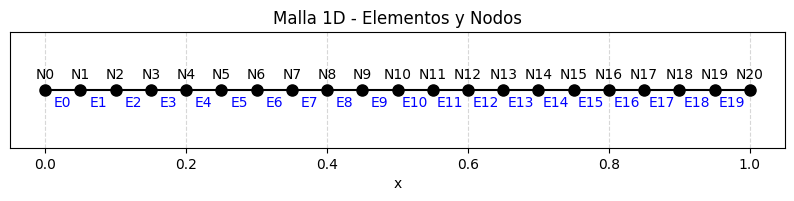

In [3]:
# mallado uniforme [0,1] con N elementos
N_elems = 20
N_nodes = N_elems + 1
Mnod = np.linspace(0.0, 1.0, N_nodes)          # coordenadas nodales
Melem = np.vstack([np.arange(0, N_elems), np.arange(1, N_elems+1)]).T  # (Ne,2)
# --- Plot de malla ---
plt.figure(figsize=(10, 1.5))
plt.plot(Mnod, np.zeros_like(Mnod), 'ko-', ms=8)   # nodos y conexiones

# Etiquetas de nodos
for i, x in enumerate(Mnod):
    plt.text(x, 0.02, f"N{i}", ha='center')

# Etiquetas de elementos
for e, (n1, n2) in enumerate(Melem):
    x_mid = 0.5*(Mnod[n1] + Mnod[n2])
    plt.text(x_mid, -0.03, f"E{e}", ha='center', color='blue')

plt.title("Malla 1D - Elementos y Nodos")
plt.yticks([])
plt.xlabel("x")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.ylim(-0.1, 0.1)
plt.show()


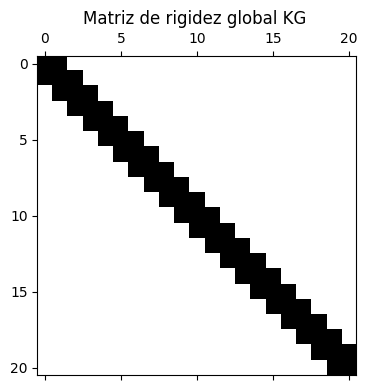

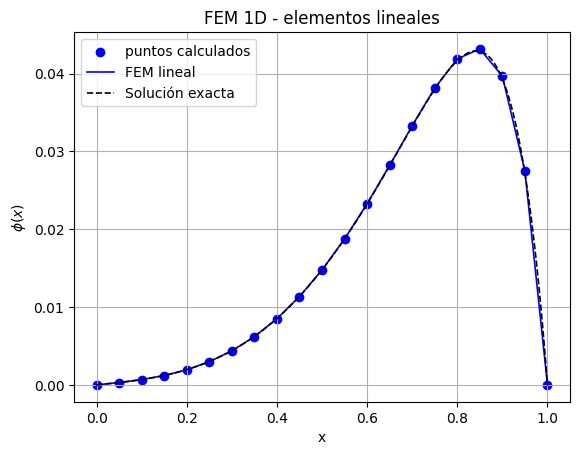

In [4]:
f_func = lambda x: x**3
# Ensamble
KG, FG = assemble_KG(Mnod, Melem, f_func, k_dif=0.1, k_reac=10.0, quad_n=2)
plt.figure(figsize=(5,4))
plt.spy(KG)
plt.title("Matriz de rigidez global KG ")
plt.tight_layout()
# Condiciones de Dirichlet: phi(0)=0, phi(1)=0
bc = {0: 0.0, N_nodes-1: 0.0}
KG_p, FG_p = apply_dirichlet_penalty(KG, FG, bc, penalty=1e20)
# Resolver
sol = np.linalg.solve(KG_p, FG_p)
# Plot solution
X = np.linspace(0, 1, 400)
phi_approx = np.zeros_like(X)
# para cada punto encontrar su elemento y evaluar Ni
elem_index = np.minimum((X * N_elems).astype(int), N_elems-1)  # índice de elemento donde cae X
for idx, x in enumerate(X):
    e = elem_index[idx]
    nodes = Melem[e]
    Nvals = np.array([Nm(x, 0, Mnod, Melem, e), Nm(x, 1, Mnod, Melem, e)])
    phi_approx[idx] = sol[nodes].dot(Nvals)
# Si quieres comparar con tu solución exacta definida antes, úsala:
def f_exacta(x):
    return -(np.exp(-10*x)*(-53*np.exp(10)+((50-50*np.exp(20))*x**3+(3-3*np.exp(20))*x)*np.exp(10*x)+53*np.exp(10+20*x)))/(500*np.exp(20)-500)

plt.figure()
plt.scatter(Mnod, sol,color="blue", label='puntos calculados')
plt.plot(X, phi_approx, "b",lw=1.2, label='FEM lineal')
plt.plot(X, f_exacta(X), 'k--', lw=1.2, label='Solución exacta')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.title('FEM 1D - elementos lineales')
plt.grid(True)
plt.show()

/tmp/ipython-input-1775244547.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error_L2 = np.sqrt(np.trapz((phi_ex - phi_approx)**2, X))


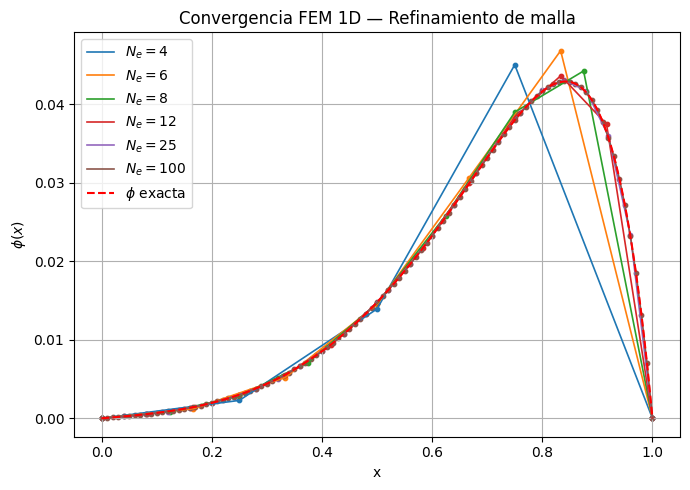

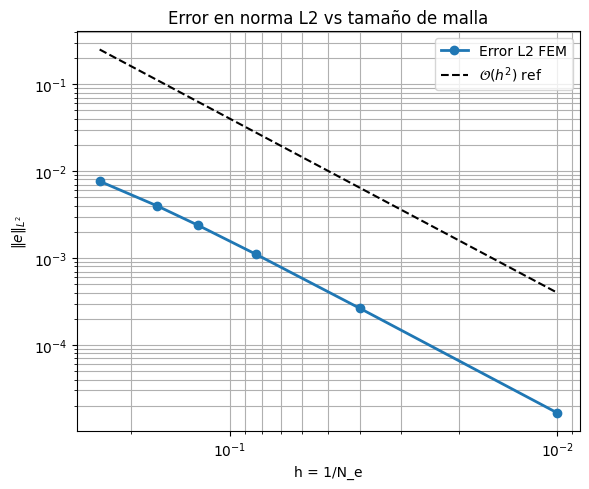

In [5]:
Ne_list = [4, 6, 8, 12,25,100]   # lista de refinamientos
f_func = lambda x: x**3

# Para almacenar los errores
errores_L2 = []
hs = []

# --- malla de referencia para evaluar la norma ---
X = np.linspace(0, 1, 2000)
dX = X[1] - X[0]

plt.figure(figsize=(7,5))

for Ne in Ne_list:

    # ----- Malla -----
    N_nodes = Ne + 1
    Mnod = np.linspace(0.0, 1.0, N_nodes)
    Melem = np.vstack([np.arange(0, Ne), np.arange(1, Ne+1)]).T

    # ----- Ensamble -----
    KG, FG = assemble_KG(Mnod, Melem, f_func, k_dif=0.1, k_reac=10.0, quad_n=2)

    # ----- Condiciones de borde -----
    bc = {0: 0.0, N_nodes-1: 0.0}
    KG_p, FG_p = apply_dirichlet_penalty(KG, FG, bc, penalty=1e20)

    # ----- Resolver -----
    sol = np.linalg.solve(KG_p, FG_p)

    # ----- Evaluación de solución FEM en la malla fina -----
    phi_approx = np.zeros_like(X)
    elem_index = np.minimum((X * Ne).astype(int), Ne-1)

    for idx, x in enumerate(X):
        e = elem_index[idx]
        nodes = Melem[e]
        Nvals = np.array([
            Nm(x, 0, Mnod, Melem, e),
            Nm(x, 1, Mnod, Melem, e)
        ])
        phi_approx[idx] = sol[nodes].dot(Nvals)

    # ----- Error L2 -----
    phi_ex = f_exacta(X)
    error_L2 = np.sqrt(np.trapz((phi_ex - phi_approx)**2, X))
    errores_L2.append(error_L2)

    # guardar tamaño de elemento h
    hs.append(1/Ne)

    # ----- Graficar solución -----
    plt.plot(X, phi_approx, lw=1.2, label=fr'$N_e={Ne}$')
    plt.scatter(Mnod, sol, s=10)

# Solución exacta
plt.plot(X, f_exacta(X), 'r--', lw=1.5, label=r'$\phi$ exacta')

plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.title('Convergencia FEM 1D — Refinamiento de malla')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# ======= GRAFICAR ERROR L2 =======

plt.figure(figsize=(6,5))
plt.loglog(hs, errores_L2, 'o-', lw=2, label='Error L2 FEM')
plt.loglog(hs, [hs[0]*(h/hs[0])**2 for h in hs], 'k--', label=r'$\mathcal{O}(h^2)$ ref')  # línea guía

plt.gca().invert_xaxis()   # para que h→0 vaya a la derecha
plt.xlabel('h = 1/N_e')
plt.ylabel(r'$\|e\|_{L^2}$')
plt.title('Error en norma L2 vs tamaño de malla')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


# Ejemplo 2
![image.png](attachment:744d4dbe-4df8-4ba6-b124-4d75158610dc.png)

![image.png](attachment:9b4c2aaf-2072-499e-99c6-fcb377ca3e3b.png)

In [6]:
def area(x):
    A=np.pi*(-x/10 + 0.25)**2
    return A
def K_e(Mnod, Melem, e, k_dif=30e9, k_reac=1, quad_n=2):
    """Matriz elemental Ke (2x2) para elemento e."""
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    xi = Mnod[nod1]
    xf = Mnod[nod2]
    Ke_diff = np.zeros((2, 2), dtype=np.float64)
    Ke_reac = np.zeros((2, 2), dtype=np.float64)
    for i_local in range(2):
        for j_local in range(2):
            integrand_diff = lambda x: k_dif * area(x) * dNm(x, i_local, Mnod, Melem, e) * dNm(x, j_local, Mnod, Melem, e)
            integrand_reac = lambda x: k_reac * Nm(x, i_local, Mnod, Melem, e) * Nm(x, j_local, Mnod, Melem, e)
            Ke_diff[i_local, j_local] = gauss_legendre_integral(integrand_diff, xi, xf, n=quad_n)
            Ke_reac[i_local, j_local] = gauss_legendre_integral(integrand_reac, xi, xf, n=quad_n)
    return Ke_diff + Ke_reac
def F_e(Mnod, Melem, e, f_func, quad_n=2):
    """Vector elemental Fe (2,) para elemento e dado f_func(x)."""
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    xi = Mnod[nod1]
    xf = Mnod[nod2]
    fe = np.zeros(2, dtype=np.float64)
    for i_local in range(2):
        integrand = lambda x: f_func(x) * Nm(x, i_local, Mnod, Melem, e)
        fe[i_local] = gauss_legendre_integral(integrand, xi, xf, n=quad_n)
    return fe
def penalizacion(K, F, dirichlet={}, neumann={}, penalty=1e20):
    K_mod = K.copy()
    F_mod = F.copy()
    # --- Condiciones de Neumann (fuerzas o flujos) ---
    for node, value in neumann.items():
        F_mod[node] += value
    # --- Condiciones de Dirichlet (penalty) ---
    for node, value in dirichlet.items():
        K_mod[node, node] += penalty
        F_mod[node] += penalty * value
    return K_mod, F_mod


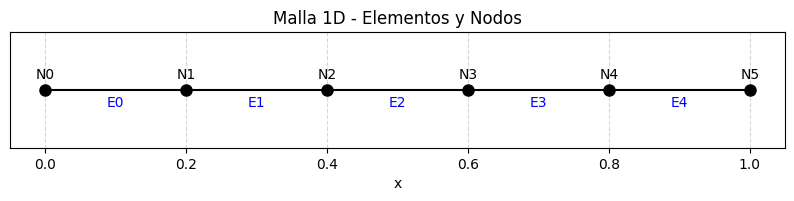

In [7]:
# mallado uniforme [0,1] con N elementos
N_elems = 5
N_nodes = N_elems + 1
Mnod = np.linspace(0.0, 1.0, N_nodes)          # coordenadas nodales
Melem = np.vstack([np.arange(0, N_elems), np.arange(1, N_elems+1)]).T  # (Ne,2)
# --- Plot de malla ---
plt.figure(figsize=(10, 1.5))
plt.plot(Mnod, np.zeros_like(Mnod), 'ko-', ms=8)   # nodos y conexiones

# Etiquetas de nodos
for i, x in enumerate(Mnod):
    plt.text(x, 0.02, f"N{i}", ha='center')

# Etiquetas de elementos
for e, (n1, n2) in enumerate(Melem):
    x_mid = 0.5*(Mnod[n1] + Mnod[n2])
    plt.text(x_mid, -0.03, f"E{e}", ha='center', color='blue')

plt.title("Malla 1D - Elementos y Nodos")
plt.yticks([])
plt.xlabel("x")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.ylim(-0.1, 0.1)
plt.show()

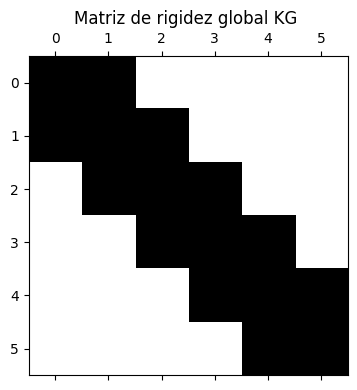

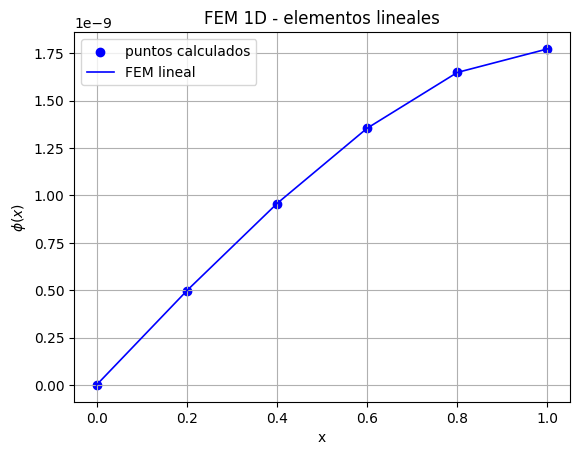

In [8]:
f_func = lambda x: 15
# Ensamble
KG, FG = assemble_KG(Mnod, Melem, f_func,k_dif=30e9, k_reac=0, quad_n=2)
plt.figure(figsize=(5,4))
plt.spy(KG)
plt.title("Matriz de rigidez global KG ")
plt.tight_layout()
dirichlet_bcs = {0: 0.0}
neumann_bcs = {N_nodes-1: 0.0}
KG_p, FG_p = penalizacion(KG, FG, dirichlet_bcs, neumann_bcs, penalty=1e20)
# Resolver
sol = np.linalg.solve(KG_p, FG_p)
# Plot solution
X = np.linspace(0, 1, 400)
phi_approx = np.zeros_like(X)
# para cada punto encontrar su elemento y evaluar Ni
elem_index = np.minimum((X * N_elems).astype(int), N_elems-1)  # índice de elemento donde cae X
for idx, x in enumerate(X):
    e = elem_index[idx]
    nodes = Melem[e]
    Nvals = np.array([Nm(x, 0, Mnod, Melem, e), Nm(x, 1, Mnod, Melem, e)])
    phi_approx[idx] = sol[nodes].dot(Nvals)
plt.figure()
plt.scatter(Mnod, sol,color="blue", label='puntos calculados')
plt.plot(X, phi_approx, "b",lw=1.2, label='FEM lineal')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.title('FEM 1D - elementos lineales')
plt.grid(True)
plt.show()

# Ejemplo 3
![image.png](attachment:bd3a6835-49df-4598-a9fe-83866c7b558d.png)
![image.png](attachment:3798eb74-f19a-417e-991c-f14e033e4bd3.png)
![image.png](attachment:07beecd1-4f1c-4260-8fed-3c9e05c72422.png)

In [9]:
def K_e(Mnod, Melem, e, k_dif=1, k_reac=1, quad_n=2):
    """Matriz elemental Ke (2x2) para elemento e."""
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    xi = Mnod[nod1]
    xf = Mnod[nod2]
    Ke_diff = np.zeros((2, 2), dtype=np.float64)
    Ke_reac = np.zeros((2, 2), dtype=np.float64)
    for i in range(2):
        for j in range(2):
            integrand_diff = lambda x: k_dif * dNm(x, i, Mnod, Melem, e) * dNm(x, j, Mnod, Melem, e)
            integrand_reac = lambda x: k_reac * Nm(x, i, Mnod, Melem, e) * Nm(x, j, Mnod, Melem, e)
            Ke_diff[i, j] = gauss_legendre_integral(integrand_diff, xi, xf, n=quad_n)
            Ke_reac[i, j] = gauss_legendre_integral(integrand_reac, xi, xf, n=quad_n)
    return Ke_diff + Ke_reac
def F_e(Mnod, Melem, e, f_func, quad_n=2):
    """Vector elemental Fe (2,) para elemento e dado f_func(x)."""
    nod1 = Melem[e, 0]
    nod2 = Melem[e, 1]
    xi = Mnod[nod1]
    xf = Mnod[nod2]
    fe = np.zeros(2, dtype=np.float64)
    for i in range(2):
        integrand = lambda x: f_func(x) * Nm(x, i, Mnod, Melem, e)
        fe[i] = gauss_legendre_integral(integrand, xi, xf, n=quad_n)
    return fe
def F_weak(Mnod, Melem,k_dif=1):
    nod1 = Melem[0, 0]
    nod2 = Melem[0, 1]
    xi = Mnod[nod1]
    xf = Mnod[nod2]
    h = xi-xf
    fweak = np.zeros(Mnod.shape[0], dtype=np.float64)
    fweak[0] += -k_dif*(1/h)
    return fweak
def penalizacion(K, F, dirichlet={}, neumann={}, penalty=1e20):
    K_mod = K.copy()
    F_mod = F.copy()
    # --- Condiciones de Neumann (fuerzas o flujos) ---
    for node, value in neumann.items():
        F_mod[node] += value
    # --- Condiciones de Dirichlet (penalty) ---
    for node, value in dirichlet.items():
        K_mod[node, node] += penalty
        F_mod[node] += penalty * value
    return K_mod, F_mod


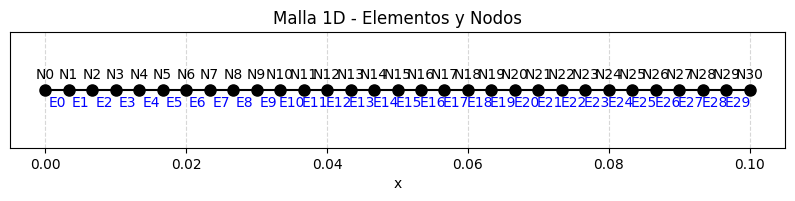

In [10]:
L = 0.1        # [m]
hc = 9.0       # [W/m^2/C]
k = 360.0      # [W/m/C]
A = 0.001      # [m^2]
p = 2.002      # [m]
Tc = 235.0     # [C]
Tinf = 20.0    # [C]
alpha = (hc*p)/(k*A)
N_elems = 30
N_nodes = N_elems + 1
Mnod = np.linspace(0.0, L, N_nodes)          # coordenadas nodales
Melem = np.vstack([np.arange(0, N_elems), np.arange(1, N_elems+1)]).T  # (Ne,2)
# --- Plot de malla ---
plt.figure(figsize=(10, 1.5))
plt.plot(Mnod, np.zeros_like(Mnod), 'ko-', ms=8)   # nodos y conexiones

# Etiquetas de nodos
for i, x in enumerate(Mnod):
    plt.text(x, 0.02, f"N{i}", ha='center')

# Etiquetas de elementos
for e, (n1, n2) in enumerate(Melem):
    x_mid = 0.5*(Mnod[n1] + Mnod[n2])
    plt.text(x_mid, -0.03, f"E{e}", ha='center', color='blue')

plt.title("Malla 1D - Elementos y Nodos")
plt.yticks([])
plt.xlabel("x")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.ylim(-0.1, 0.1)
plt.show()

[235.         231.97125266 229.06039582 226.26581056 223.58594264
 221.01930163 218.56446004 216.22005259 213.98477541 211.85738531
 209.83669913 207.92159304 206.11100191 204.40391878 202.79939422
 201.29653585 199.89450785 198.59253046 197.38987956 196.28588629
 195.27993665 194.37147117 193.55998458 192.84502558 192.22619653
 191.70315325 191.27560486 190.94331357 190.70609456 190.56381591
 190.51639848]


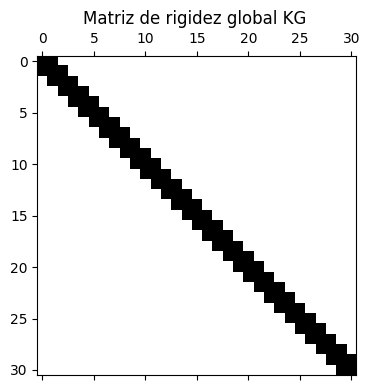

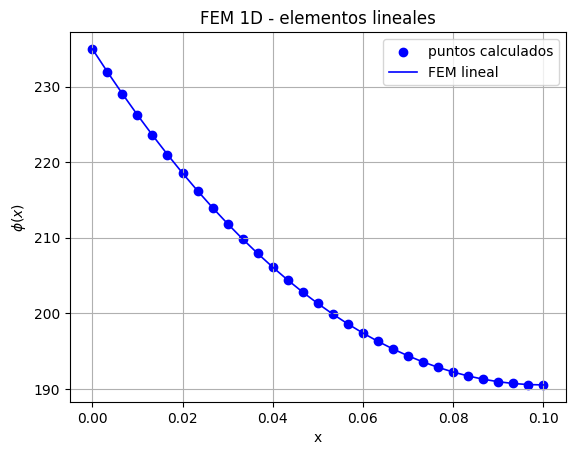

In [11]:
f_func = lambda x: alpha*Tinf
#Ensamble
KG, FG = assemble_KG(Mnod, Melem, f_func,k_dif=1, k_reac=alpha, quad_n=2)
plt.figure(figsize=(5,4))
plt.spy(KG)
plt.title("Matriz de rigidez global KG ")
plt.tight_layout()
dirichlet_bcs = {0: Tc}
neumann_bcs = {N_nodes-1: 0.0}
KG_p, FG_p = penalizacion(KG, FG, dirichlet_bcs, neumann_bcs, penalty=1e20)
Fw = F_weak(Mnod, Melem,k_dif=-k*A)
# Resolver
sol = np.linalg.solve(KG_p, FG_p+Fw)
print(sol)
C1 = np.sqrt(alpha)
def T_exact(x):
    return np.exp(-C1*x) * (
        np.exp(2*C1*L)*Tc
        + np.exp(2*C1*x)*Tc
        - np.exp(2*C1*L)*Tinf
        + np.exp(C1*x)*Tinf
        - np.exp(2*C1*x)*Tinf
        + np.exp(2*C1*L + C1*x)*Tinf
    ) / (1 + np.exp(2*C1*L))
X = np.linspace(0, L, 400)
phi_approx = np.zeros_like(X)
# para cada punto encontrar su elemento y evaluar Ni
elem_index = np.minimum((X * N_elems).astype(int), N_elems-1)  # índice de elemento donde cae X
for idx, x in enumerate(X):
    e = elem_index[idx]
    nodes = Melem[e]
    Nvals = np.array([Nm(x, 0, Mnod, Melem, e), Nm(x, 1, Mnod, Melem, e)])
    phi_approx[idx] = sol[nodes].dot(Nvals)
plt.figure()
plt.scatter(Mnod, sol,color="blue", label='puntos calculados')
plt.plot(Mnod, sol, "b",lw=1.2, label='FEM lineal')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.title('FEM 1D - elementos lineales')
plt.grid(True)
plt.show()
